In [61]:
# load required modules
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely import wkt



In [62]:


# --- Load cadastre and roads files---
cadastre = gpd.read_file("cadastre.gpkg")
roads = gpd.read_file("roads.gpkg")

# --- Step 1: Reproject to projected CRS (meters) ---
projected_crs = "EPSG:7856"  # GDA2020 MGA zone; adjust if needed
cadastre = cadastre.to_crs(projected_crs)
roads = roads.to_crs(projected_crs)

# --- Step 2: sjoin_nearest ---
cadastre_nearest = gpd.sjoin_nearest(
    cadastre,
    roads,                 # include only geometry if no other cols
    how="left",
    distance_col="dist_to_road"
)

# Inspect columns
print(cadastre_nearest.columns)

# The nearest road geometry is now in 'geometry_right' only if roads had additional cols.
# If roads only had 'geometry', then cadastre_nearest['geometry'] = parcel geometry.
# In that case, we manually extract nearest road geometry using index_right:
cadastre_nearest["geometry_road"] = roads.loc[cadastre_nearest["index_right"]].geometry.values
print(cadastre_nearest.columns)


Index(['state', 'sa4', 'geometry', 'index_right', 'osm_id', 'code', 'fclass',
       'name', 'layer', 'bridge', 'tunnel', 'fname', 'type', 'width',
       'population', 'ref', 'oneway', 'maxspeed', 'dist_to_road'],
      dtype='object')
Index(['state', 'sa4', 'geometry', 'index_right', 'osm_id', 'code', 'fclass',
       'name', 'layer', 'bridge', 'tunnel', 'fname', 'type', 'width',
       'population', 'ref', 'oneway', 'maxspeed', 'dist_to_road',
       'geometry_road'],
      dtype='object')


In [63]:
#--compute azimuthal angle--#
def line_azimuth(line):
    if line is None or line.is_empty:
        return np.nan
    if line.geom_type.startswith("Multi"):
        line = list(line.geoms)[0]
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]
    angle = np.degrees(np.arctan2((x2 - x1), (y2 - y1)))
    return (angle + 360) % 360

cadastre_nearest["azimuth"] = cadastre_nearest["geometry_road"].apply(line_azimuth)
print(cadastre_nearest["azimuth"])

0       189.534618
0       343.443162
1       343.443162
2        72.321502
3        72.321502
           ...    
1289     81.120186
1290     81.120186
1291     81.120186
1292     81.120186
1293     81.120186
Name: azimuth, Length: 1473, dtype: float64


In [64]:
#-- convert azimutal to cardinal angle----#
def azimuth_to_cardinal(angle):
    if pd.isna(angle):
        return None
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = int((angle + 22.5) // 45) % 8
    return dirs[ix]

cadastre_nearest["orientation"] = cadastre_nearest["azimuth"].apply(azimuth_to_cardinal)
cadastre_nearest["orientation"]


0       S
0       N
1       N
2       E
3       E
       ..
1289    E
1290    E
1291    E
1292    E
1293    E
Name: orientation, Length: 1473, dtype: object

In [66]:

# Load properties with pandas
gnaf_df = pd.read_parquet("gnaf_prop.parquet")

# Identify geometry in GNAF
# Example: if GNAF has lon/lat columns
if {"longitude", "latitude"}.issubset(gnaf_df.columns):
    gnaf = gpd.GeoDataFrame(
        gnaf_df,
        geometry=gpd.points_from_xy(gnaf_df["longitude"], gnaf_df["latitude"]),
        crs="EPSG:4326"
    )
elif "geometry" in gnaf_df.columns:
    gnaf = gpd.GeoDataFrame(
        gnaf_df,
        geometry=gnaf_df["geometry"].apply(wkt.loads),
        crs="EPSG:4326"
    )
else:
    raise ValueError("Cannot find geometry in GNAF dataset")
gnaf = gnaf.to_crs(projected_crs)

# Keep only geometry and address in GNAF
gnaf_for_join = gnaf[['address', 'geometry']].copy()

# Reset index to avoid conflicts
gnaf_for_join = gnaf_for_join.reset_index(drop=True)

# Perform nearest join
cadastre_nearest =cadastre_nearest.rename({'index_right':'rt_idx'}, axis=1)
print(cadastre_nearest.head())
cadastre_with_address = gpd.sjoin_nearest(
    cadastre_nearest,
    gnaf_for_join,
    how='left',
    distance_col='dist_to_address'
)



  state                                sa4  \
0   NSW  Sydney - North Sydney and Hornsby   
0   NSW  Sydney - North Sydney and Hornsby   
1   NSW  Sydney - North Sydney and Hornsby   
2   NSW  Sydney - North Sydney and Hornsby   
3   NSW  Sydney - North Sydney and Hornsby   

                                            geometry  rt_idx      osm_id  \
0  MULTIPOLYGON (((334341.254 6259167.939, 334393...      19   507890154   
0  MULTIPOLYGON (((334341.254 6259167.939, 334393...       4  1081035341   
1  MULTIPOLYGON (((334357.587 6259229.986, 334384...       4  1081035341   
2  MULTIPOLYGON (((334386.743 6259103.77, 334449....       3   507890155   
3  MULTIPOLYGON (((334408.411 6259070.466, 334420...       3   507890155   

   code   fclass                         name  layer bridge  ...  type width  \
0  5154     path                         None    0.0      F  ...  None  None   
0  5154     path  Harold Reid Foreshore Track    0.0      F  ...  None  None   
1  5154     path  Harold R

In [60]:
# ------------------------
# Step 6: Prepare output
# ------------------------

# Keep only relevant columns
output = cadastre_with_address[['address', 'orientation', 'geometry']]

# Ensure one row per property (unique by geometry or address)
# Option 1: Unique by geometry
output = output.drop_duplicates(subset=['geometry'])

# Option 2: Unique by address (if address is unique per property)
# output = output.drop_duplicates(subset=['address'])

# Drop any rows with missing values
output = output.dropna(subset=['address', 'orientation'])

# Save CSV
output[['address', 'orientation']].to_csv("property_orientations.csv", index=False)

# Save GeoPackage (optional)
output.to_file(
    "property_orientations.gpkg",
    layer="property_orientation",
    driver="GPKG"
)

print("✅ Finished: property_orientations.csv and property_orientations.gpkg created with one property per row")


✅ Finished: property_orientations.csv and property_orientations.gpkg created with one property per row


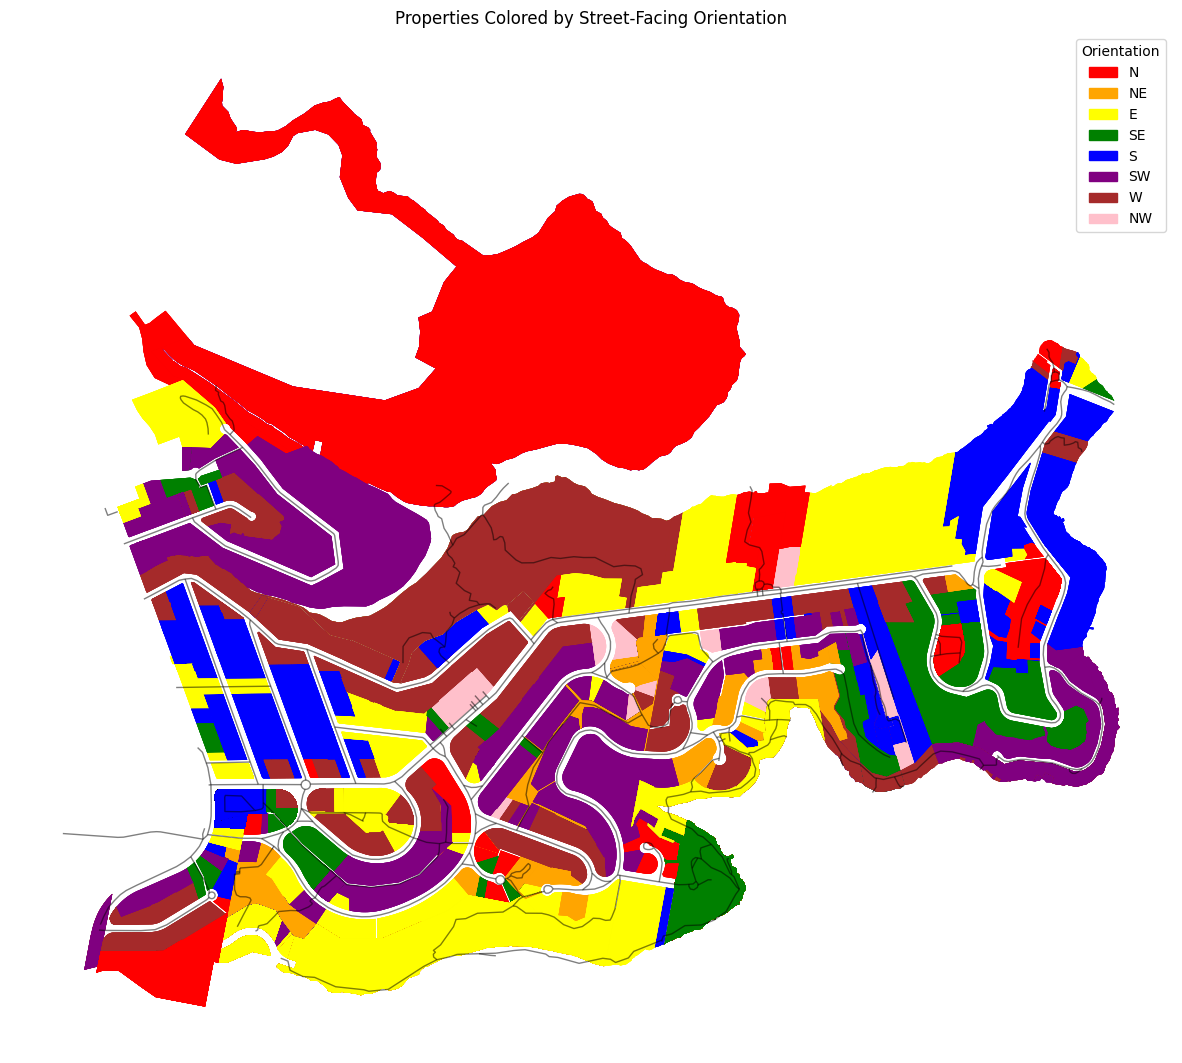

In [73]:
import matplotlib.pyplot as plt

# Reproject to web mercator for plotting
cadastre_plot = cadastre_with_address.to_crs(epsg=3857)
roads_plot = roads.to_crs(epsg=3857)

# Define colors for each orientation
orientation_colors = {
    'N': 'red',
    'NE': 'orange',
    'E': 'yellow',
    'SE': 'green',
    'S': 'blue',
    'SW': 'purple',
    'W': 'brown',
    'NW': 'pink'
}

# Map colors to property points
cadastre_plot['color'] = cadastre_plot['orientation'].map(orientation_colors)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot roads as black lines
roads_plot.plot(ax=ax, color='black', linewidth=1, alpha=0.5)

# Plot properties as points colored by orientation
cadastre_plot.plot(ax=ax, color=cadastre_plot['color'], markersize=10)

# Add legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=o) for o, c in orientation_colors.items()]
plt.legend(handles=handles, title="Orientation")

plt.title("Properties Colored by Street-Facing Orientation")
plt.axis('off')
plt.show()
